In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

INPUT_DIR = os.getcwd() + '/ChAI/Data/eikon/'
STORE_DIR = os.getcwd() + '/experiment_result/'

In [2]:
def log_returns(x, lag=1):
    """Calculate log returns between adjacent close prices"""
    return np.log(x) - np.log(x.shift(lag))

def get_closed_price(file_name):
    load_csv = INPUT_DIR + file_name
    df = pd.read_csv(load_csv, index_col=0, parse_dates=True, dayfirst=True).sort_index(ascending=True)
    df = df[['CLOSE']]
    # stock price comes from london, care for about 1 day lag. 
    if 'stock' in file_name:
        df.index = pd.Series(index=df.index).tshift(periods=1, freq='D').index
    # add pct_change    
    pct_change = df.pct_change()
    df['pct_change'] = pct_change
    # add log return 
    log_return = log_returns(df['CLOSE'])
    df['log_return'] = log_return
    return df

In [3]:
#process Cu data
cu_shfe_prices = get_closed_price('cu_shfe_prices.csv')
cu_lme_stocks = get_closed_price('cu_lme_stocks.csv')
cu_lme_prices = get_closed_price('cu_lme_prices.csv')

#process Al data
al_shfe_prices = get_closed_price('al_shfe_prices.csv')
al_lme_stocks = get_closed_price('al_lme_stocks.csv')
al_lme_prices = get_closed_price('al_lme_prices.csv')

ted = get_closed_price('ted.csv')
ted_spread = get_closed_price('ted_spread.csv')
bdi = get_closed_price('bdi.csv')
vix = get_closed_price('vix.csv')
gsci = get_closed_price('gsci.csv')

/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
#check mean and variance
from sklearn import preprocessing

def generate_dataset(metal_type, preprocess_method):
#select feature that we want to use 
    if metal_type is 'Cu':
        shfe_price = cu_shfe_prices[[preprocess_method]]
        lme_stocks = cu_lme_stocks[[preprocess_method]]
        lme_prices = cu_lme_prices[[preprocess_method]]
        ted_ = ted[[preprocess_method]]
        ted_spread_ = ted_spread[[preprocess_method]]
        bdi_ = bdi[[preprocess_method]]
        vix_ = vix[[preprocess_method]]
        gsci_ = gsci[[preprocess_method]]
        frames = [lme_stocks, lme_prices, ted_, ted_spread_, bdi_, vix_, gsci_, shfe_price]
        result = pd.concat(frames, axis = 1)
        result.columns = ['lme_stocks', 'lme_prices', 'ted', 'ted_spread', 'bdi', 'vix', 'gsci', 'shfe_price']
        result = collect_available_period(result, 'Cu')
        return result
    elif metal_type is 'Al':
        shfe_price = al_shfe_prices[[preprocess_method]]
        lme_stocks = al_lme_stocks[[preprocess_method]]
        lme_prices = al_lme_prices[[preprocess_method]]
        ted_ = ted[[preprocess_method]]
        ted_spread_ = ted_spread[[preprocess_method]]
        bdi_ = bdi[[preprocess_method]]
        vix_ = vix[[preprocess_method]]
        gsci_ = gsci[[preprocess_method]]
        frames = [lme_stocks, lme_prices, ted_, ted_spread_, bdi_, vix_, gsci_, shfe_price]
        result = pd.concat(frames, axis = 1)
        result.columns = ['lme_stocks', 'lme_prices', 'ted', 'ted_spread', 'bdi', 'vix', 'gsci', 'shfe_price']
        result = collect_available_period(result, 'Al')
        return result
    elif metal_type is 'All':
        shfe_cu_price = cu_shfe_prices[[preprocess_method]]
        shfe_al_price = al_shfe_prices[[preprocess_method]]
        lme_cu_stocks = cu_lme_stocks[[preprocess_method]]
        lme_al_stocks = al_lme_stocks[[preprocess_method]]
        lme_cu_prices = cu_lme_prices[[preprocess_method]]
        lme_al_prices = al_lme_prices[[preprocess_method]]
        ted_ = ted[[preprocess_method]]
        ted_spread_ = ted_spread[[preprocess_method]]
        bdi_ = bdi[[preprocess_method]]
        vix_ = vix[[preprocess_method]]
        gsci_ = gsci[[preprocess_method]]
        frames = [lme_cu_stocks, lme_al_stocks, lme_cu_prices, lme_al_prices, ted_, ted_spread_, bdi_, vix_, \
                  gsci_, shfe_cu_price, shfe_al_price]
        result = pd.concat(frames, axis = 1)
        result.columns = ['lme_cu_stocks', 'lme_al_stocks', 'lme_cu_prices','lme_al_prices','ted', \
                          'ted_spread', 'bdi', 'vix', 'gsci', 'shfe_cu_price', 'shfe_al_price']
        result = collect_available_period(result, 'All')
        return result
    else:
        print('Please Enter metal type from Cu, Al or All')
        
def collect_available_period(df_Xy, metal_type):
    # remove output is null
    if metal_type is 'All':
        df_Xy.dropna(axis=0, how='any', subset=['shfe_cu_price','shfe_al_price'], inplace=True)
    else:
        df_Xy.dropna(axis=0, how='any', subset=['shfe_price'], inplace=True)
    
    # Find first and last dates for which all features available
    start_date = df_Xy.loc[df_Xy.notnull().all(axis=1)].index.min()
    end_date = df_Xy.loc[df_Xy.notnull().all(axis=1)].index.max()
    df_Xy = df_Xy.loc[start_date:end_date, :]
    
    #fill nan by forward value 
    df_Xy = df_Xy.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
    
    #normalised to zero mean and standard variance
    for item in df_Xy.columns:
        df_Xy[item] = preprocessing.scale(df_Xy[item])
    
    return df_Xy

In [5]:
cu_log_return = generate_dataset('Cu', 'log_return')

In [6]:
al_log_return = generate_dataset('Al', 'log_return')

In [22]:
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.linalg import norm
from dtw import dtw
from scipy.stats import spearmanr

def evaluate(model_name, org_price, pred_price):
    
    org_price = org_price.reshape(len(org_price),1)
    pred_price = pred_price.reshape(len(pred_price),1)
    
    mse = compute_mse_error(org_price, pred_price)
    mae = compute_mean_absolute_error(org_price, pred_price)
    rmse =compute_root_mean_square_error(org_price, pred_price)
    dtw_dist, dtw_cost, dtw_acc, dtw_path = compute_dtw(org_price, pred_price)
    corr_rank, p_value = compute_spearmanr(org_price, pred_price)
    
    df = pd.DataFrame(index=[model_name],columns=['MSE', 'MAE', 'RMSE' ,'DTW', 'Spearmanr', 'p-value'])
    df.set_value(model_name, 'MSE', mse)
    df.set_value(model_name, 'MAE', mae)
    df.set_value(model_name, 'RMSE', rmse)
    df.set_value(model_name, 'DTW', dtw_cost[-1][-1])
    df.set_value(model_name, 'Spearmanr', corr_rank)
    df.set_value(model_name, 'p-value', p_value)
    return df

def compute_daily_error(org_price, pred_price):
    return org_price - pred_price

#MSE
def compute_mse_error(org_price, pred_price):
    return mean_squared_error(org_price, pred_price)

#MAE
def compute_mean_absolute_error(org_price, pred_price):  
    return mean_absolute_error(org_price, pred_price)

#RMSE
def compute_root_mean_square_error(org_price, pred_price):
    return np.sqrt(((org_price - pred_price) ** 2).mean())

#smaller dtw Accumulated Distortion(cost[-1][-1]) means more similar time series
def compute_dtw(x, y):   #Dynamic time warping
    #custom norm 
    #def my_custom_norm(x, y):
    #    return (x * x) + (y * y)
    #dist, cost, acc, path = dtw(x, y, dist=my_custom_norm)
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    return dist, cost, acc, path

def compute_spearmanr(org_price, pred_price):
    correlation_rank = spearmanr(org_price, pred_price)
    return correlation_rank[0], correlation_rank[1]

In [8]:
def run_experiment(function, input_dataset, start_num, period=1500, day=1):
    
    num, feature = input_dataset.shape
    # i is start date. the total data num is 2493 * 8 
    # 2872
    # Consider efficiency, run small data size for testing
    i = start_num
    df = pd.DataFrame(data=[], index=input_dataset.index[(i+period +day) :], columns=['org_price','pred_price','error']) 
    
    while (i+period+day) != num :  
   
        X = input_dataset.iloc[i:i+period, :]
        
        Y = input_dataset.iloc[i+day:i+period+day, -1]  
                
        x_pred = input_dataset.iloc[i+period:i+period+1, :]
        
        y_pred = function(X, Y, x_pred)
        
        y_org = input_dataset.iloc[i+period+day, -1]
        
        error = np.abs(y_org - y_pred)
        pred_date = input_dataset.index[i+period+day].strftime('%Y-%m-%d')
        
        df.set_value(pred_date, 'org_price', y_org)
        df.set_value(pred_date, 'pred_price', y_pred)
        df.set_value(pred_date, 'error',error)
        print(pred_date, "%.8f" % y_org, "%.8f" % y_pred, "%.8f" %error) 
        i=i+1
        
    return df

In [99]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY, MonthLocator
import matplotlib as mpl

def plot_result(result_name, metal_name, pointer=0):
    plt.plot(result_name.index[pointer:], result_name['pred_price'][pointer:] , c='r', label='pred_return')
    plt.plot(result_name.index[pointer:], result_name['org_price'][pointer:], c='b', label='org_return')
    monthsLoc = mpl.dates.MonthLocator()
    weeksLoc = mpl.dates.WeekdayLocator()
    monthsFmt = mpl.dates.DateFormatter('%b')
    fig = plt.gcf()
    fig.set_size_inches(20,10)
    plt.gcf().autofmt_xdate() 
    plt.ylabel(metal_name+' shfe price log return')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import Kernel

In [88]:
from mklaren.mkl.align import Align
class mkl_kernel_ridge_regression:
    
    def __init__(self):
        #store kernels in array
        self.kernel = []
        self.test_kernel =[]
        # self.cov = combined kernel
        self.cov = 0
        # self.invcov = inverse combined kernel
        self.invcov =0
        # the range of kernel's hyperparameter from 1e-05 to 1e5, bound_num is Number of samples to generate from range
        self.bound_num = 11
        # 7 different type of kernel, each kernel have 11 hyperparameter choices
        self.kernel_num = self.bound_num * 3
        self.evaluation = []
        # weights of each kernel
        self.weights = np.zeros(shape=(self.kernel_num,1))  *  (1/self.kernel_num)
        # initial weights of each kernel
        self.init =  np.ones(shape=(self.kernel_num,1)) *  (1/self.kernel_num)
        self.alpha = []
        self.alpha_ = []
        # gradient for every update
        self.grad = np.zeros(shape=(self.kernel_num,1)) 
        self.grad_ = np.zeros(shape=(self.kernel_num,1)) 
        
    def feed_kernel(self, X, x_pred):

        x_len=X.shape[0]
        X_all = np.vstack((X,x_pred))
        x_all_len = X_all.shape[0]
        
        bound = np.logspace(-5, 5, self.bound_num)
        
        kernel = np.zeros(shape=(self.kernel_num, x_all_len, x_all_len))
        i = 0
        while i < self.kernel_num-1:
            for hyper_param in bound:
                k1 = ConstantKernel(constant_value= hyper_param, constant_value_bounds=(1e-05, 100000.0))
                k2 = RBF(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0))
                k3 = Matern(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
                k4 = RationalQuadratic(length_scale=hyper_param, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
                k5 = ExpSineSquared(length_scale=hyper_param, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
                k6 = DotProduct(sigma_0=hyper_param, sigma_0_bounds=(1e-05, 100000.0))
                k7 = WhiteKernel(noise_level=hyper_param, noise_level_bounds=(1e-05, 100000.0))

                kernel[i] = k6(X_all, X_all)
                kernel[i+1] = k4(X_all, X_all)
                kernel[i+2] = k7(X_all, X_all)
#                 kernel[i+3] = k4(X_all, X_all)
#                 kernel[i+4] = k5(X_all, X_all)            
#                 kernel[i+5] = k6(X_all, X_all)
#                 kernel[i+6] = k7(X_all, X_all)
                i = i+3
    
        self.kernel = kernel[:,0:-1,0:-1]
        self.test_kernel = kernel[:,-1:,0:-1]

    def compute_alpha(self, weights, Y):
        self.cov = np.sum(weights[:,:,None]*self.kernel,axis=0)
        self.invcov  = np.linalg.inv(self.cov)
        return np.dot(self.invcov, Y)
            
    def compute_evla(self, Y, alpha):
        K = np.sum(self.weights[:,:,None]* self.kernel, axis=0)
        result = -np.dot(alpha.T, alpha)+ 2* np.dot(alpha.T, Y) - np.dot(self.init.T, self.grad) - np.linalg.norm(self.weights-self.init, ord=2)* np.linalg.norm(self.grad, ord=2)
        #print(result)
        return result[0][0]
            

    #compute weight of multiple kernel    
    def fit(self, X, Y): 
#         model = Align()
#         model.fit(self.kernel, Y)
#         self.weights = model.mu.reshape(self.kernel_num, 1)
#         self.alpha = self.compute_alpha(self.weights, Y)
       
        
        self.alpha = self.compute_alpha(self.init, Y)
        #print(self.compute_evla(Y, self.alpha))
        #self.evaluation.append(self.compute_evla(Y, self.alpha))
        for j in range(5):

            for i in range(self.kernel_num):

                self.grad[i] = np.dot(np.dot(self.alpha.T, self.kernel[i]), self.alpha)

            self.grad_ = self.grad / np.linalg.norm(self.grad,ord=2) 

            self.weights = self.init +  np.linalg.norm(self.weights-self.init, ord=2) * self.grad_
        
            #print(self.weights)
            self.alpha = self.compute_alpha(self.weights, Y)
            
            self.evaluation.append(self.compute_evla(Y, self.alpha))
            
        #print(np.sum(self.weights.reshape((self.bound_num, 7)), axis=0))
              
        plt.plot(self.evaluation)
        plt.show()
    

        
    
#     def log_likelihood(self, Y):
#         return (1/2)*np.dot(np.dot(Y.T, self.invcov), Y)+(1/2)*np.log(np.linalg.det(self.cov))+ (1/2)*np.dot(np.dot(Y.T, self.invcov), Y)
    
    
    def pred(self, X, Y, x_pred):
       
        kernel_test = np.sum(self.weights[:,:,None]* self.test_kernel, axis=0) 
        
        mean =  np.dot(kernel_test, self.alpha)
        
        return mean
    

In [89]:
def mkl_krr(X, Y, x_pred):    
    krr =  mkl_kernel_ridge_regression()
    X = X.values
    Y = Y.values
    x_pred = x_pred.values
    krr.feed_kernel(X, x_pred)
    krr.fit(X,Y)
    y_pred = krr.pred(X,Y,x_pred)
    del krr
    return y_pred

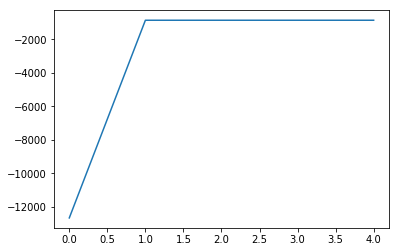

/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


2017-09-29 -0.29908910 -0.10845542 0.19063368


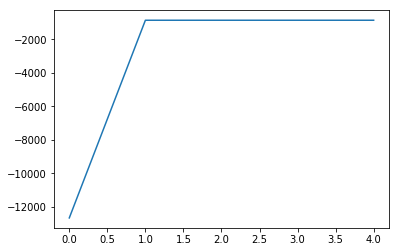

2017-10-09 1.27911090 -0.55805351 1.83716441


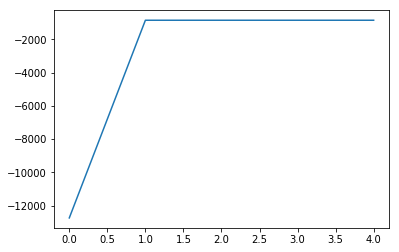

2017-10-10 0.28311481 0.56856585 0.28545104


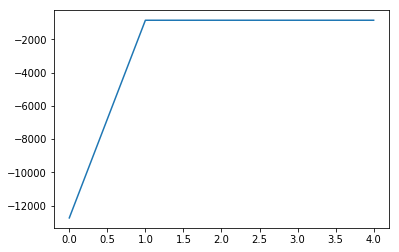

2017-10-11 -1.66794461 -0.07593107 1.59201354


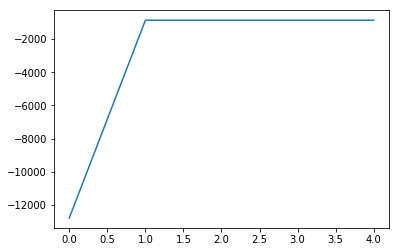

2017-10-12 -0.12739948 -0.98814404 0.86074456


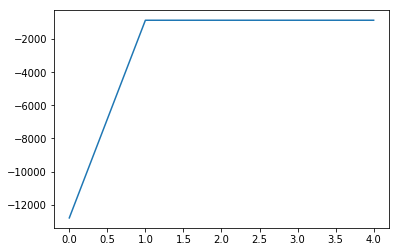

2017-10-13 1.17966998 0.26994914 0.90972084


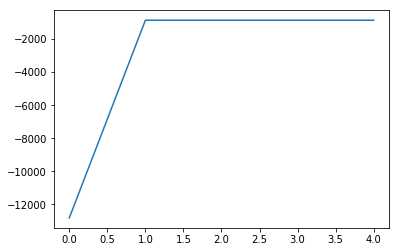

2017-10-16 -0.19463899 -0.00221640 0.19242259


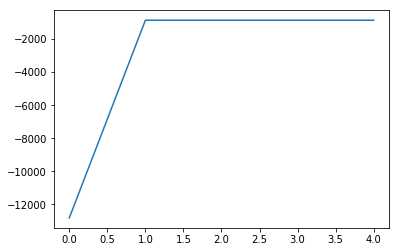

2017-10-17 -0.09208342 -0.03092360 0.06115982


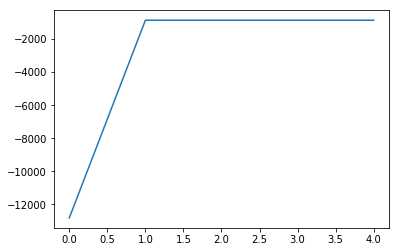

2017-10-18 -1.36953076 0.03085943 1.40039018


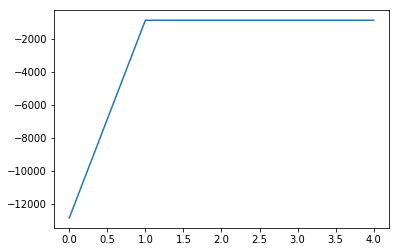

2017-10-19 -0.86064711 -0.44040799 0.42023912


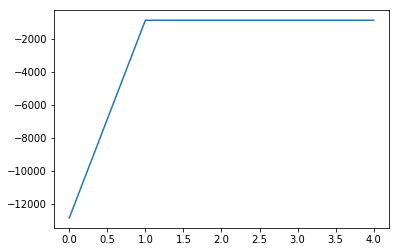

2017-10-20 1.33261985 0.72228986 0.61032999


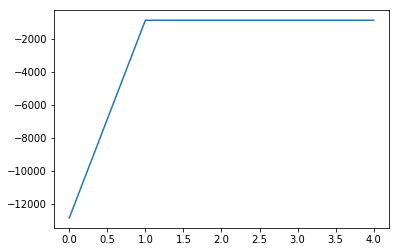

2017-10-23 -0.02383153 -0.13441116 0.11057962


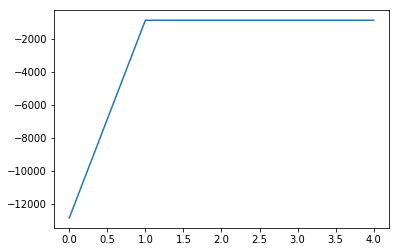

2017-10-24 0.18358174 -0.14528532 0.32886706


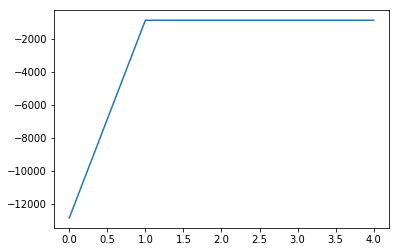

2017-10-25 0.18331532 0.33628991 0.15297459


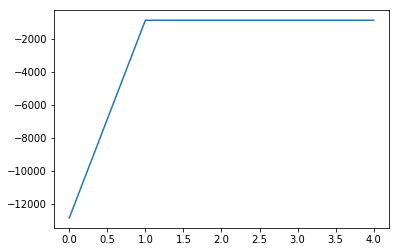

2017-10-26 0.93801117 0.53634827 0.40166290


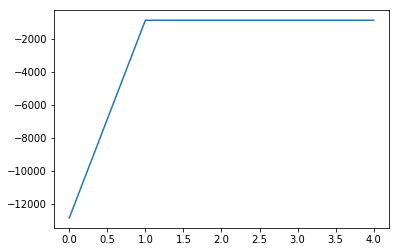

2017-10-27 -0.50343854 0.26472729 0.76816584


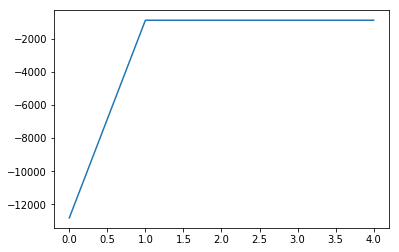

2017-10-30 -0.64396601 -0.54475194 0.09921407


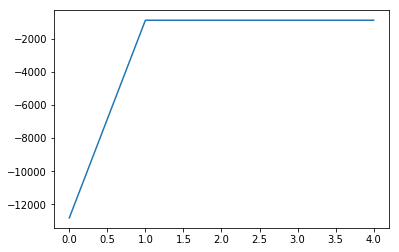

2017-10-31 -0.12757020 -0.05270196 0.07486824


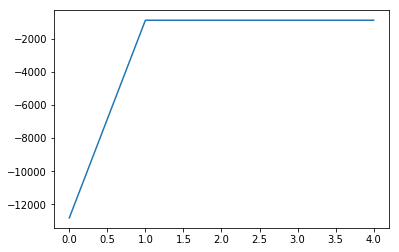

2017-11-01 0.32174713 -0.10083320 0.42258033


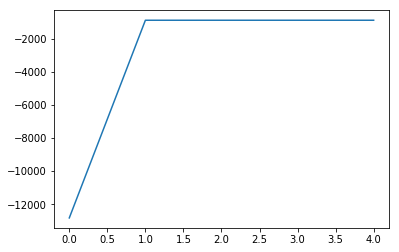

2017-11-02 -1.20354218 0.56284970 1.76639188


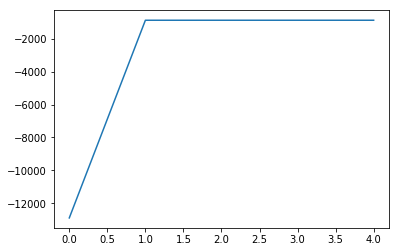

2017-11-03 0.01075514 -0.41232789 0.42308303


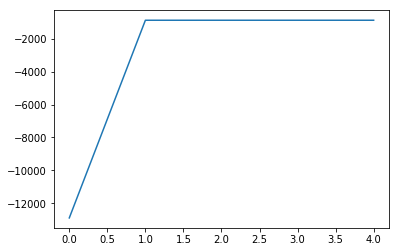

2017-11-06 -0.61890771 0.34454006 0.96344777


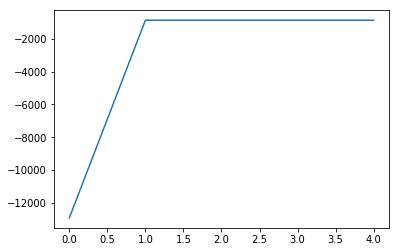

2017-11-07 -0.41099645 -0.14819503 0.26280142


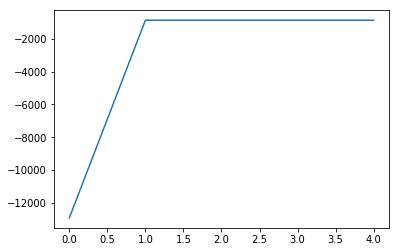

2017-11-08 -1.33537222 -0.70316884 0.63220338


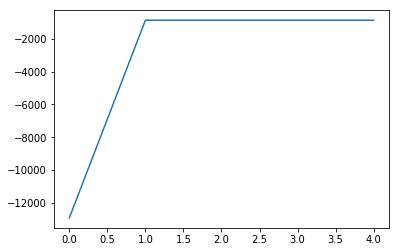

2017-11-09 -2.40284261 -0.61407226 1.78877035


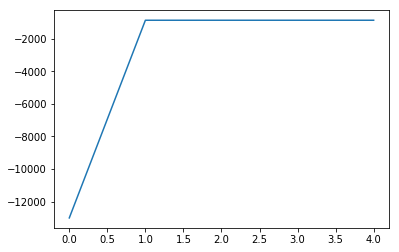

2017-11-10 -0.20794848 -0.74801648 0.54006800


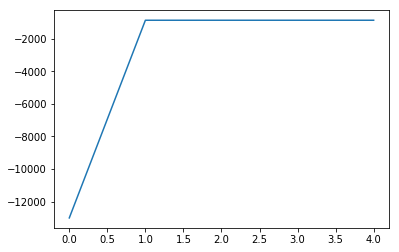

2017-11-13 0.30226512 0.00253212 0.29973299


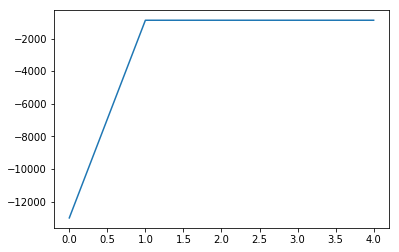

2017-11-14 -0.39026709 0.04713443 0.43740152


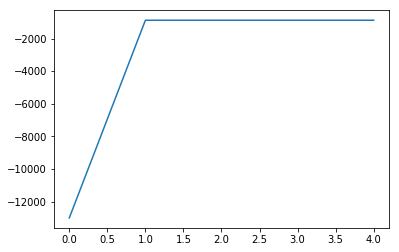

2017-11-15 -0.42836841 -0.65114480 0.22277639


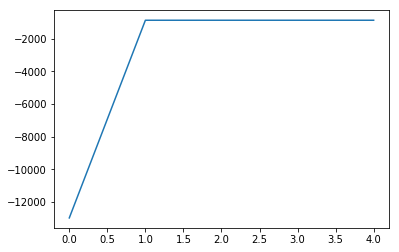

2017-11-16 1.25049163 0.26658654 0.98390509


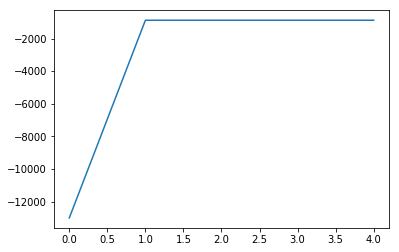

2017-11-17 -0.57094032 0.31959862 0.89053893


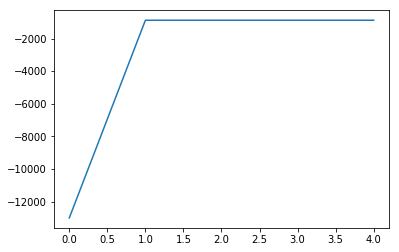

2017-11-20 -1.34610715 0.06554216 1.41164931


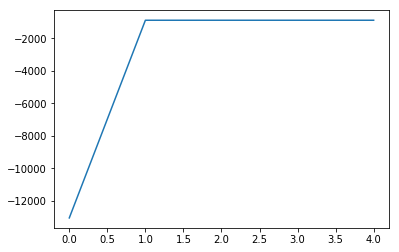

2017-11-21 -1.92442202 -0.70193589 1.22248614


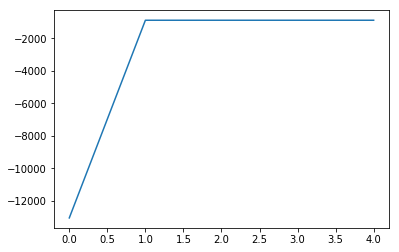

2017-11-22 -0.62922510 -0.68582392 0.05659882


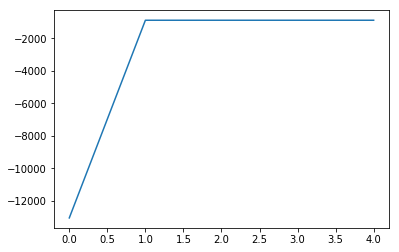

2017-11-23 0.98807296 0.56071539 0.42735757


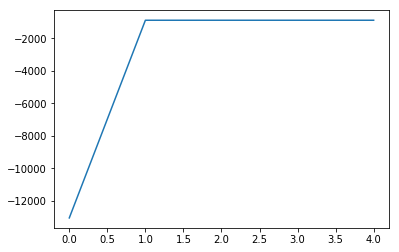

2017-11-24 -0.25153063 0.40522146 0.65675209


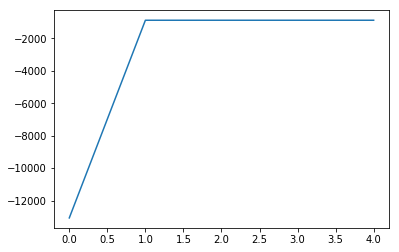

2017-11-27 0.08575666 0.37147135 0.28571468


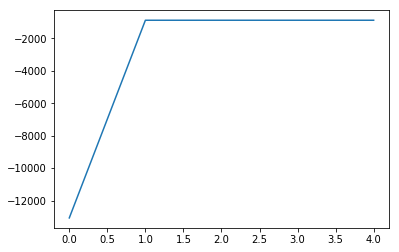

2017-11-28 -1.19534157 0.08247796 1.27781953


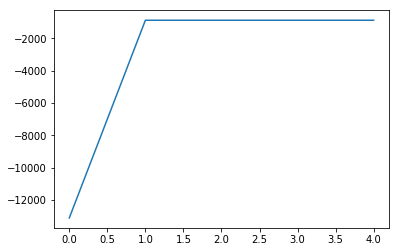

2017-11-29 -1.59222836 -0.89893734 0.69329101


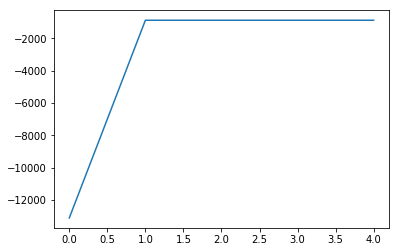

2017-11-30 -1.65452727 -0.69162935 0.96289792


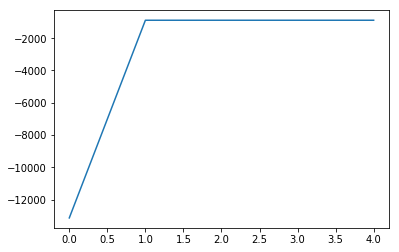

2017-12-01 1.02062805 -0.66314477 1.68377281


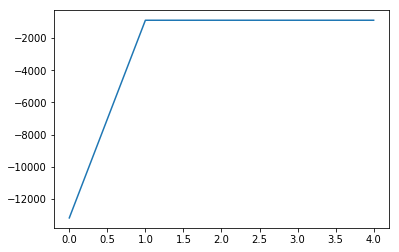

2017-12-04 0.12669484 0.89497268 0.76827784


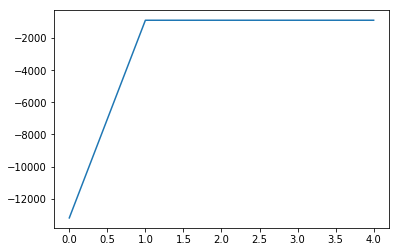

2017-12-05 -0.02787808 -0.11723858 0.08936050


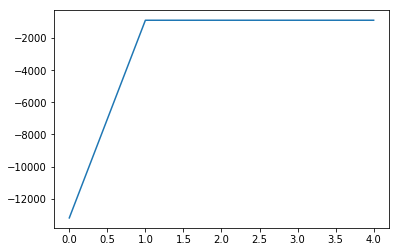

2017-12-06 -2.25309696 -0.33710859 1.91598837


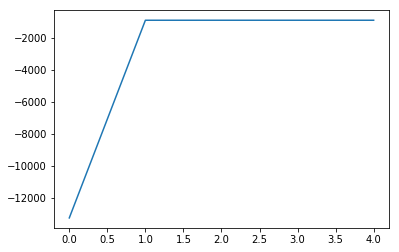

2017-12-07 -1.29803296 -1.13881385 0.15921911


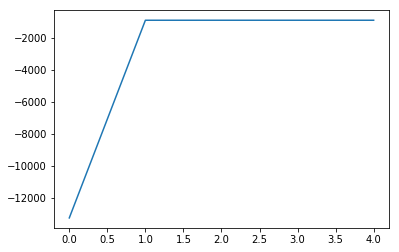

2017-12-08 0.21004266 -0.38480280 0.59484546


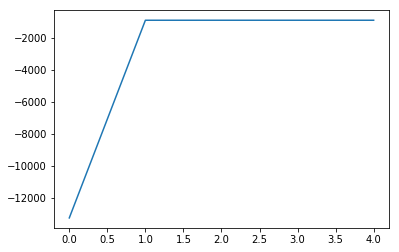

2017-12-11 0.24943278 0.03679031 0.21264246


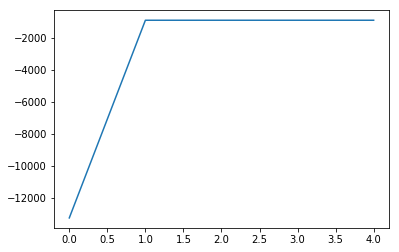

2017-12-12 -0.26775162 0.19897136 0.46672298


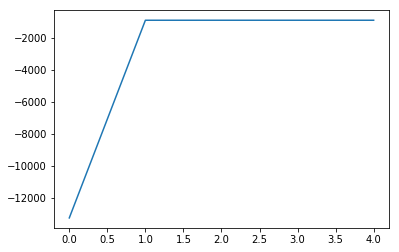

2017-12-13 -0.10881735 -0.31704217 0.20822482


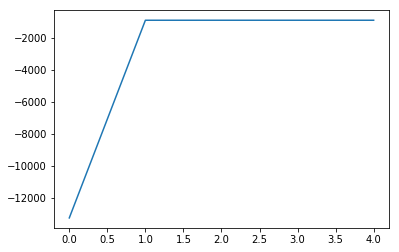

2017-12-14 0.13032763 0.02487609 0.10545154


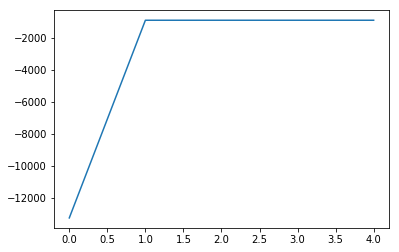

2017-12-15 0.92325875 0.91406333 0.00919541


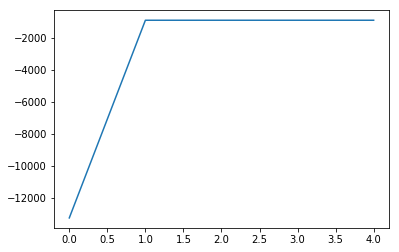

2017-12-18 1.85262029 0.56002182 1.29259847


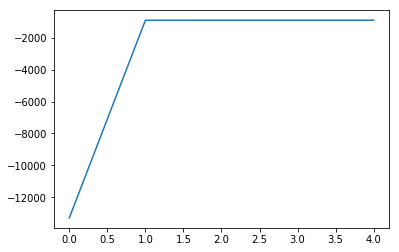

2017-12-19 -0.14482483 0.55884922 0.70367404


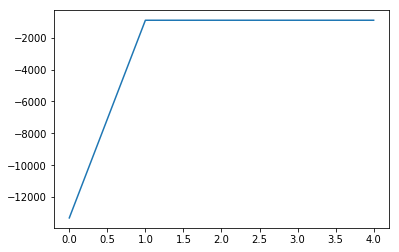

2017-12-20 1.01818111 0.71700591 0.30117520


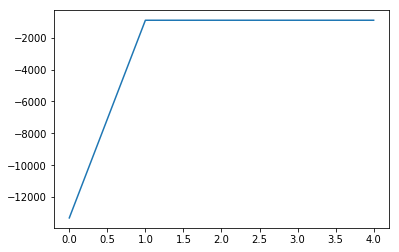

2017-12-21 0.43425950 0.65300357 0.21874408


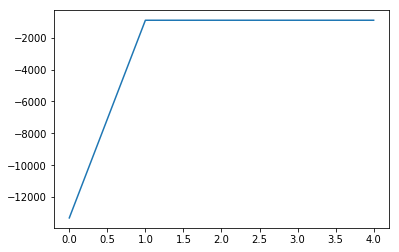

2017-12-22 -0.18154824 0.62040277 0.80195100


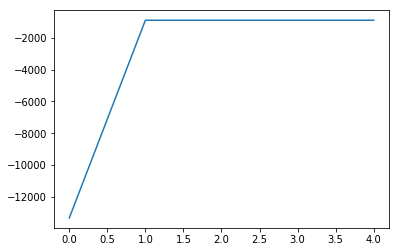

2017-12-25 0.96898534 0.78300989 0.18597545


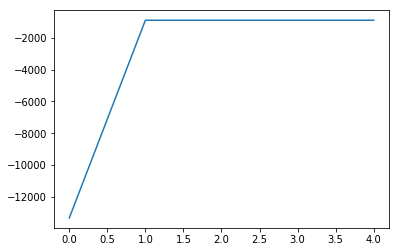

2017-12-26 -1.44901544 1.03089952 2.47991496


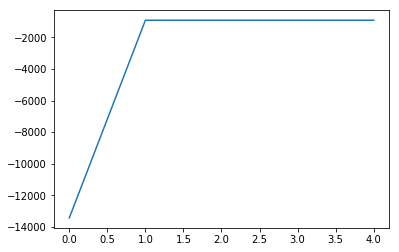

2017-12-27 1.08821740 0.45712304 0.63109436


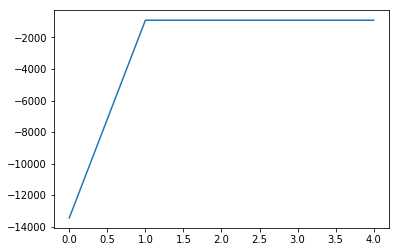

2017-12-28 1.41882110 0.67708451 0.74173660


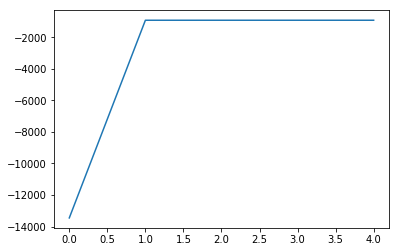

2017-12-29 1.66247853 0.72926879 0.93320975


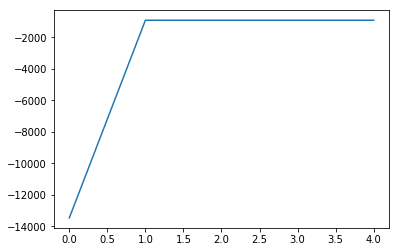

2018-01-02 0.27129670 0.16405272 0.10724397


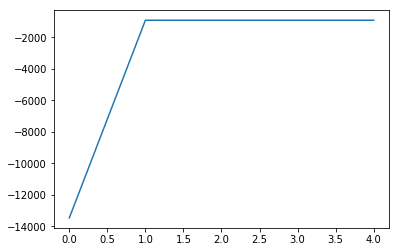

2018-01-03 -0.62304374 -0.27257130 0.35047245


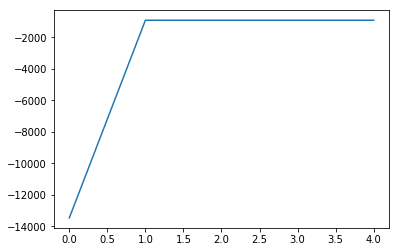

2018-01-04 -0.40127057 -0.91332844 0.51205787


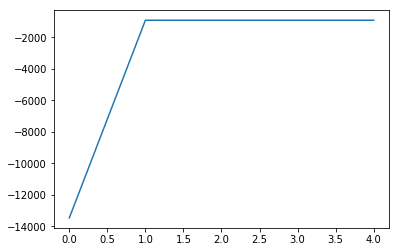

2018-01-05 0.38538658 0.31596911 0.06941747


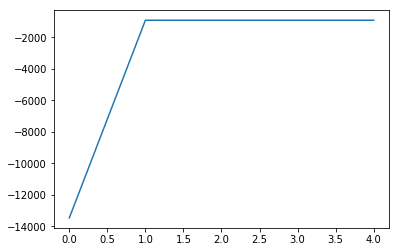

2018-01-08 -0.62686630 -0.57757426 0.04929204


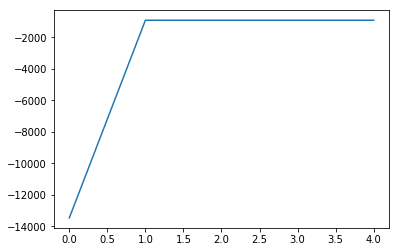

2018-01-09 -0.17747387 -0.66709003 0.48961616


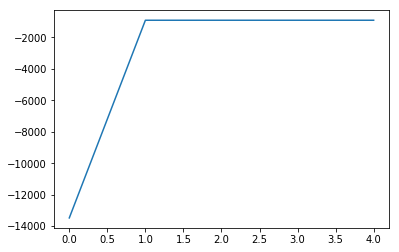

2018-01-10 0.04842627 -0.54636818 0.59479445


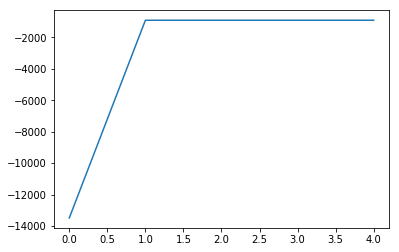

2018-01-11 1.02311298 0.57671040 0.44640258


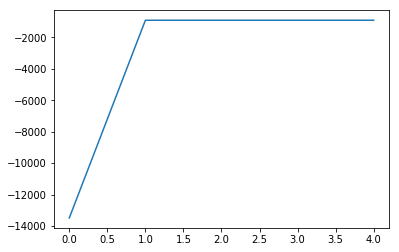

2018-01-12 -0.43805175 0.17834699 0.61639874


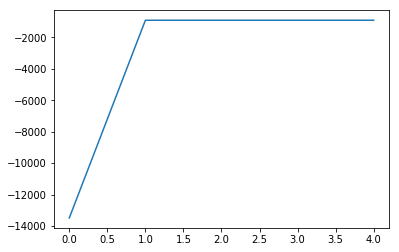

2018-01-15 0.64603512 0.62312752 0.02290760


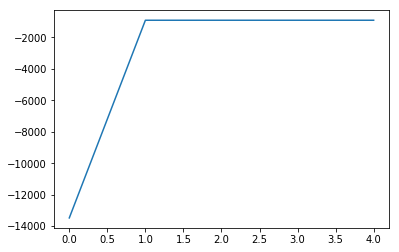

2018-01-16 -1.71662880 0.29526937 2.01189816


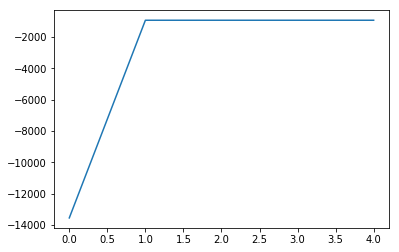

2018-01-17 -1.85908504 -0.82757640 1.03150864


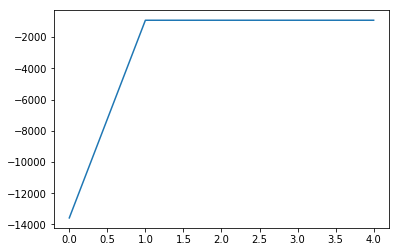

2018-01-18 -0.02773197 -0.24449998 0.21676801


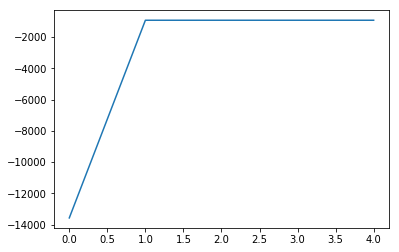

2018-01-19 0.81621866 0.83102430 0.01480565


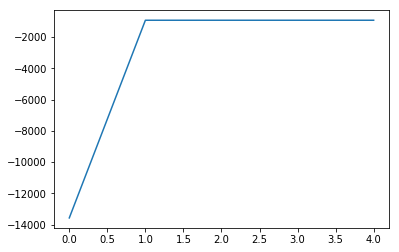

2018-01-22 -0.48718135 -0.25473545 0.23244590


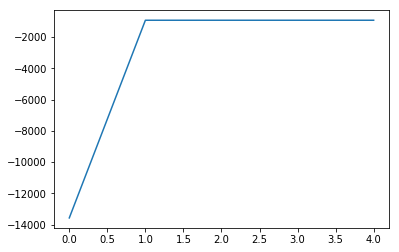

2018-01-23 -0.02763957 0.58954155 0.61718112


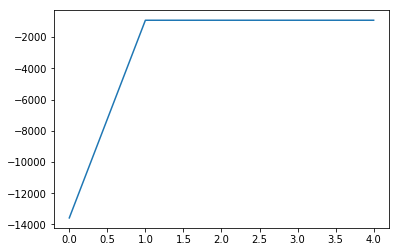

2018-01-24 -0.14295552 -0.36279583 0.21984031


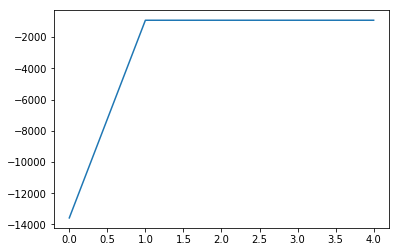

2018-01-25 0.73900821 0.33470240 0.40430581


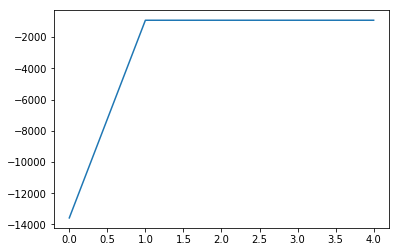

2018-01-26 -0.29530046 -0.13555586 0.15974460


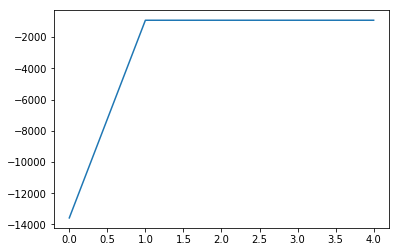

2018-01-29 0.01075514 0.29940446 0.28864932


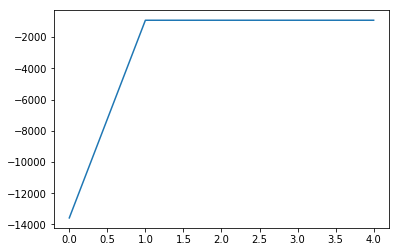

2018-01-30 -1.22190445 -0.49068928 0.73121517


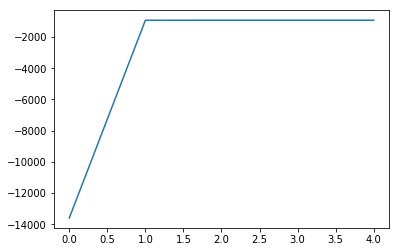

2018-01-31 -0.45501433 -0.53484505 0.07983072


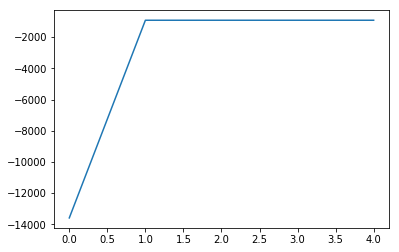

2018-02-01 -0.88742329 0.13544216 1.02286545


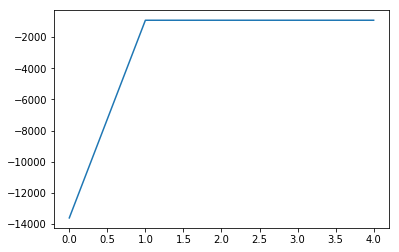

2018-02-02 0.28487750 0.06436682 0.22051068


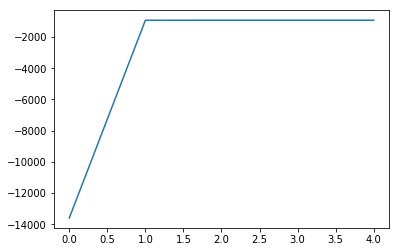

2018-02-05 -0.53816251 -0.36858696 0.16957555


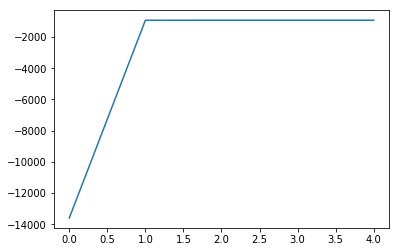

2018-02-06 -0.58037333 -0.09448528 0.48588805


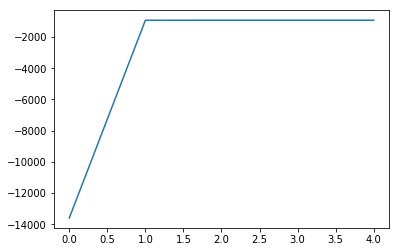

2018-02-07 -0.34542614 -0.87531918 0.52989304


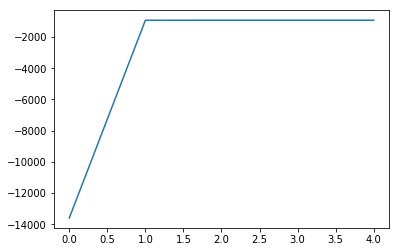

2018-02-08 0.48541211 -0.22728452 0.71269663


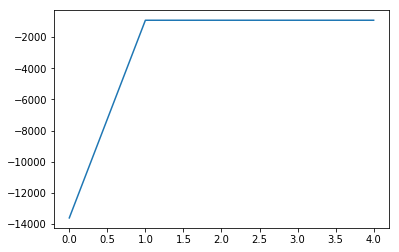

2018-02-09 -0.58288122 0.26261878 0.84550000


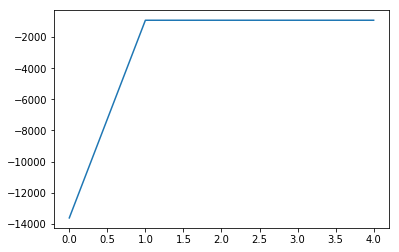

2018-02-12 0.56491354 -1.97028095 2.53519449


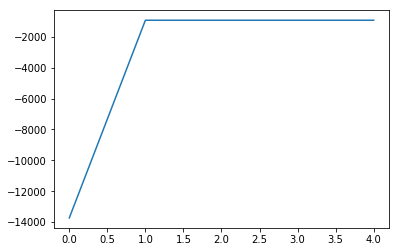

2018-02-13 0.99355134 -0.51661539 1.51016673


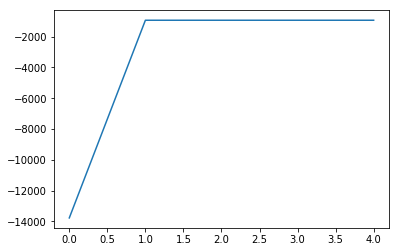

2018-02-14 -0.65660649 -1.49603319 0.83942670


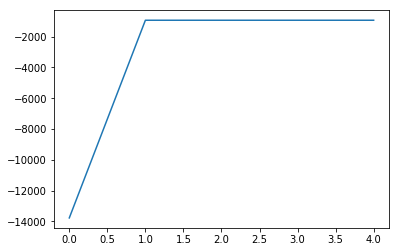

2018-02-22 -1.09717667 0.48759618 1.58477285


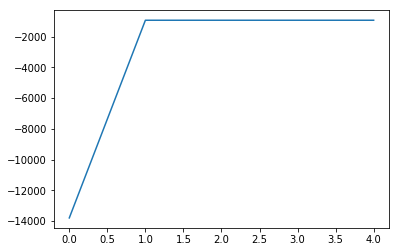

2018-02-23 1.07930621 -0.22528100 1.30458721


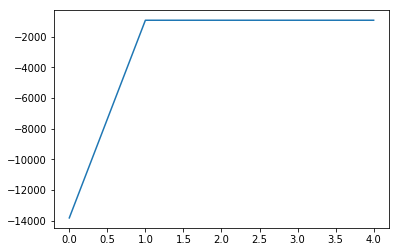

2018-02-26 -0.06804794 -0.41628993 0.34824199


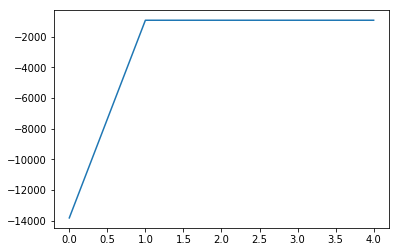

2018-02-27 -0.30501310 -0.05851576 0.24649735


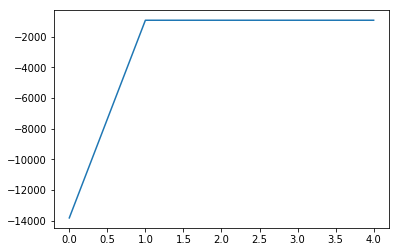

2018-02-28 0.24766479 -0.13833107 0.38599586


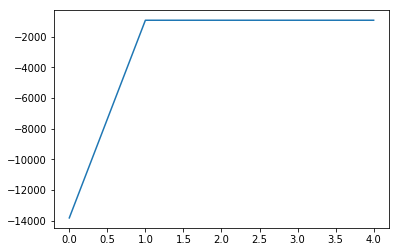

2018-03-01 0.60084490 -0.08940056 0.69024546


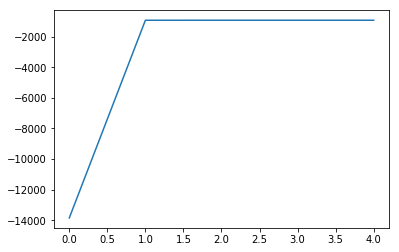

2018-03-02 0.28506943 -0.15368682 0.43875625


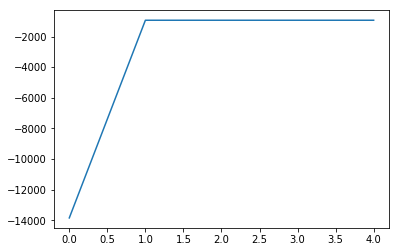

2018-03-05 -1.16963999 -0.14071006 1.02892994


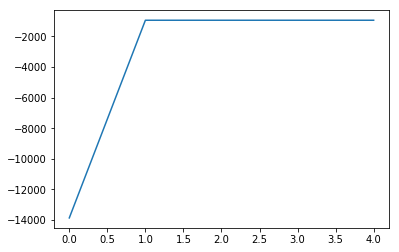

2018-03-06 0.60250860 -0.31802762 0.92053621


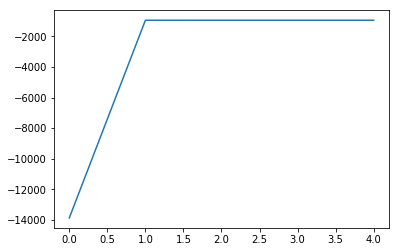

2018-03-07 -0.30445737 0.04600406 0.35046142


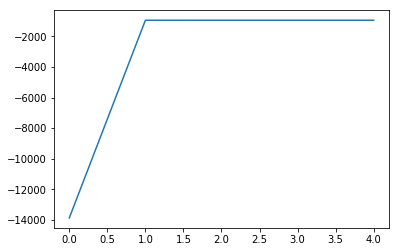

2018-03-08 -1.17926069 -0.93283960 0.24642109


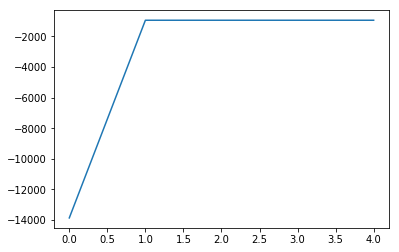

2018-03-09 0.01075514 0.05203840 0.04128326


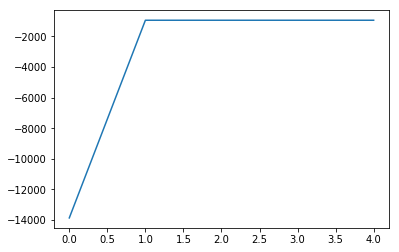

2018-03-12 -0.74951788 0.37903375 1.12855163


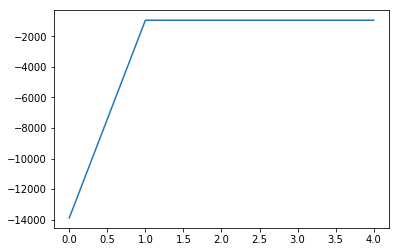

2018-03-13 -1.56617213 -0.60337067 0.96280146


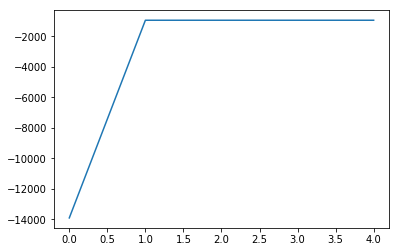

2018-03-14 0.17351746 -0.13561213 0.30912959


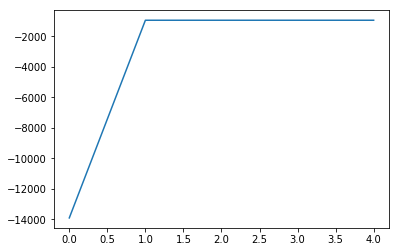

2018-03-15 0.25445575 -0.32610643 0.58056218


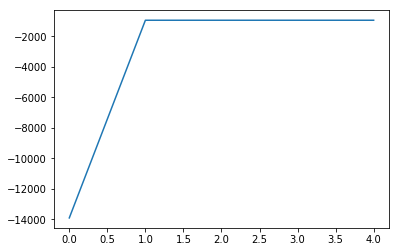

2018-03-16 0.61769555 -0.12652910 0.74422465


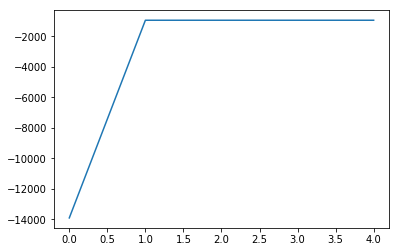

2018-03-19 0.25261285 0.15284193 0.09977093


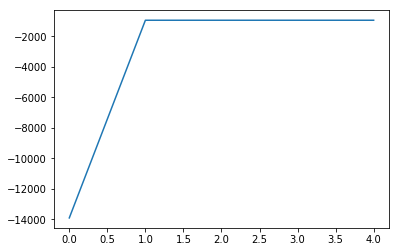

2018-03-20 0.05101400 -0.11750543 0.16851944


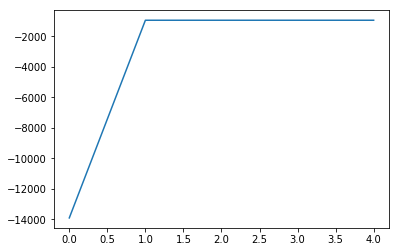

2018-03-21 -0.63513064 0.01043513 0.64556577


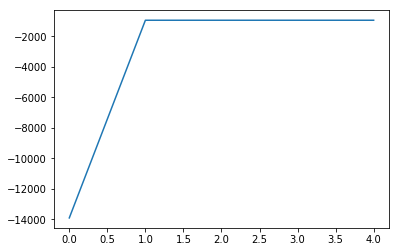

2018-03-22 0.25339924 0.12653232 0.12686693


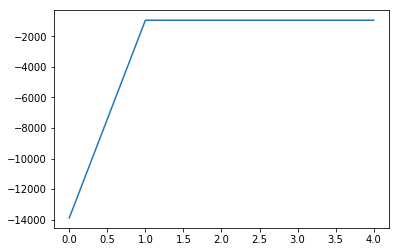

2018-03-23 -1.33034362 -0.10410434 1.22623928


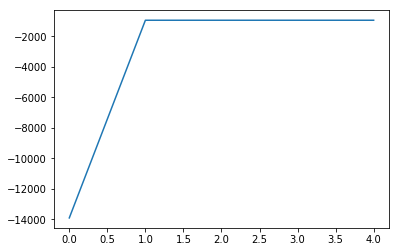

2018-03-26 -0.48092838 -0.55947781 0.07854943


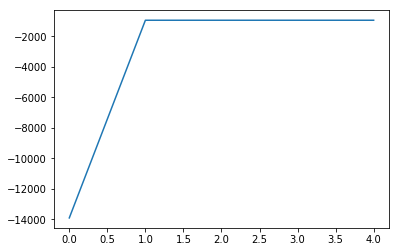

2018-03-27 0.78825985 -0.13403635 0.92229621


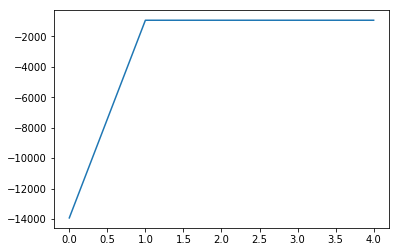

2018-03-28 -0.07083361 -0.15986061 0.08902700


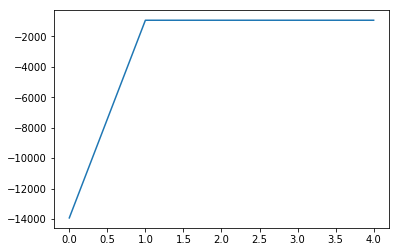

2018-03-29 0.41810555 -0.26280133 0.68090687


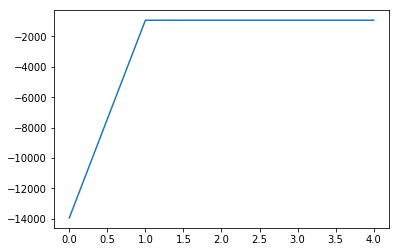

2018-03-30 -0.47824353 -0.42279756 0.05544597


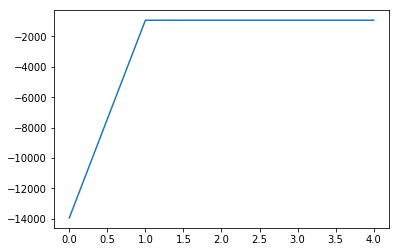

2018-04-02 1.14844679 -0.35458477 1.50303156


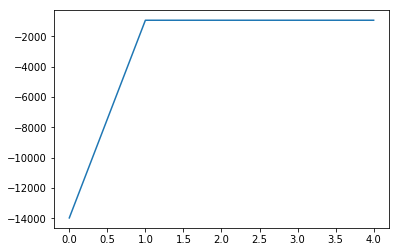

2018-04-03 1.57637182 -0.01310349 1.58947531


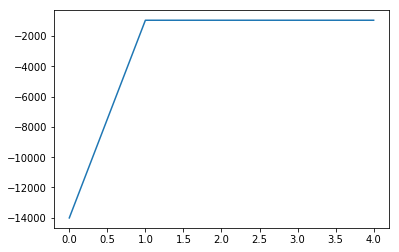

2018-04-04 -0.38860229 -0.53241420 0.14381191


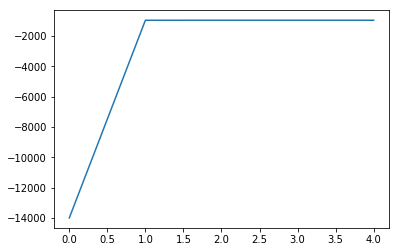

2018-04-09 1.20457842 0.17604597 1.02853245


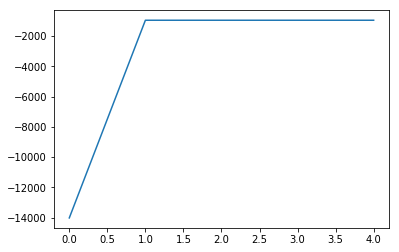

2018-04-10 1.11361892 2.59433472 1.48071580


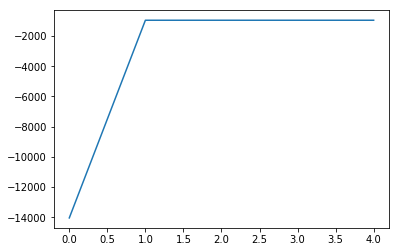

2018-04-11 0.24567604 1.11903536 0.87335932


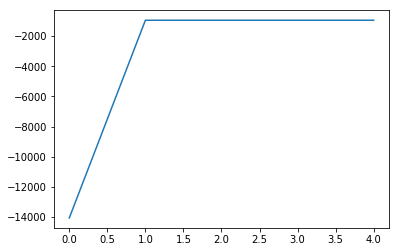

2018-04-12 -0.49886472 0.99778390 1.49664861


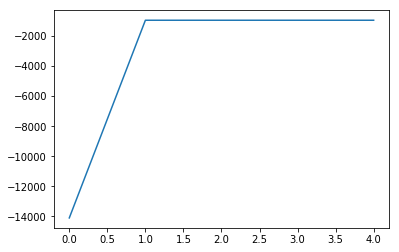

2018-04-13 1.84236053 1.04735267 0.79500786


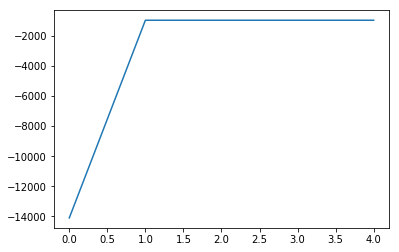

2018-04-16 0.28100131 -0.99236107 1.27336238


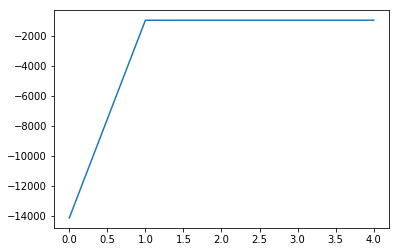

2018-04-17 1.96024207 1.86491466 0.09532741


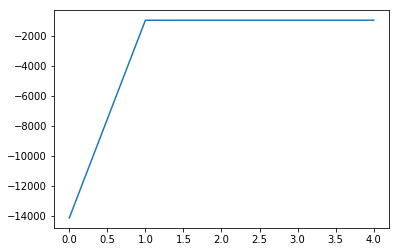

2018-04-18 0.20006648 0.04136631 0.15870017


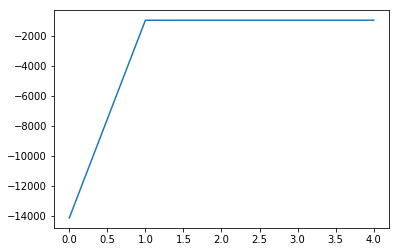

2018-04-19 2.96014759 1.86151811 1.09862948


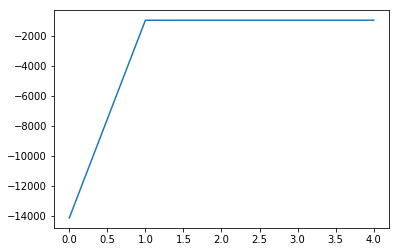

2018-04-20 -1.77199948 0.09813821 1.87013770


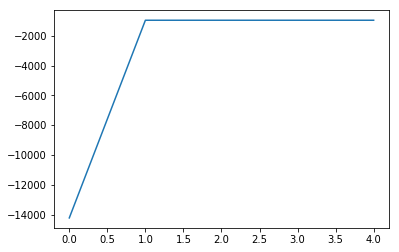

2018-04-23 -0.51460846 -0.47603357 0.03857489


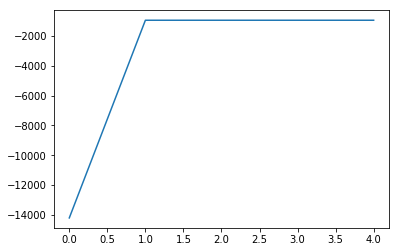

2018-04-24 -3.97110649 -2.91178030 1.05932619


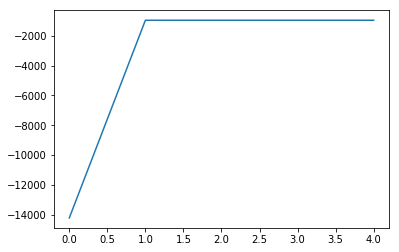

2018-04-25 0.01075514 -2.09563053 2.10638567


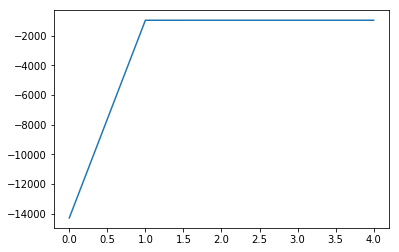

2018-04-26 -0.34058182 0.38122737 0.72180920


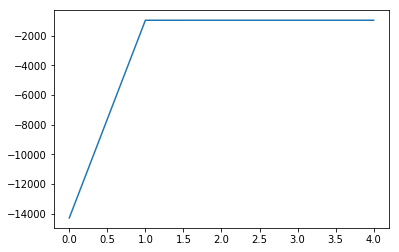

2018-04-27 0.51788860 0.50844753 0.00944108


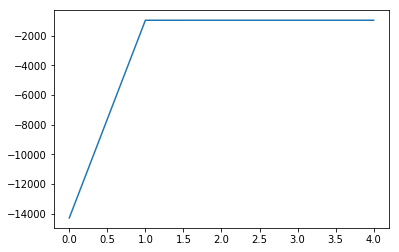

2018-05-02 -0.22302100 -0.85222046 0.62919946


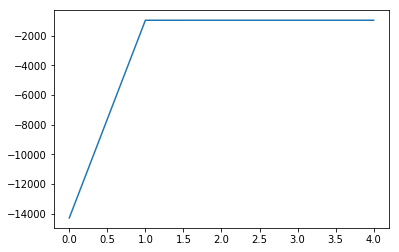

2018-05-03 0.86555794 1.00505799 0.13950005


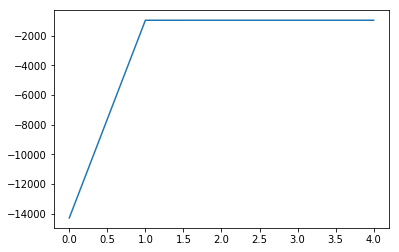

2018-05-04 0.39715445 -0.69264957 1.08980402


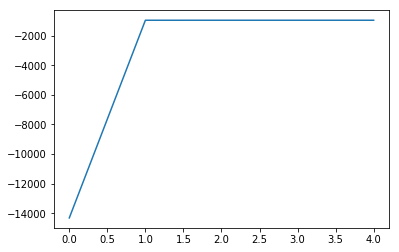

2018-05-07 0.54948315 1.58479857 1.03531542


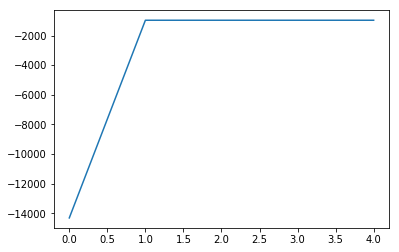

2018-05-08 0.35571618 1.61996573 1.26424955


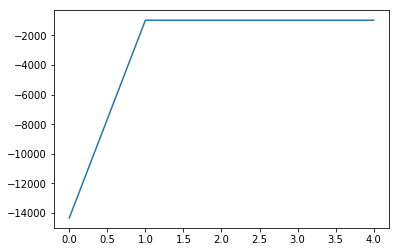

2018-05-09 -0.60324581 0.31149232 0.91473814


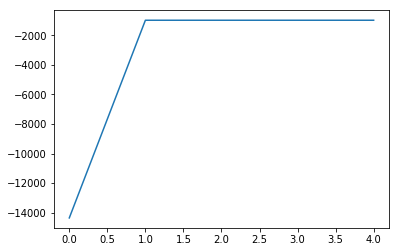

2018-05-10 -0.22036628 -0.24281669 0.02245041


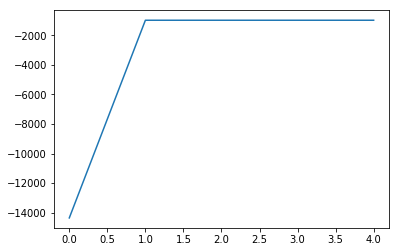

2018-05-11 0.51091648 -0.92555301 1.43646948


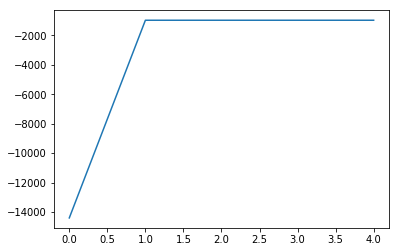

2018-05-14 -0.41231269 -0.65697718 0.24466449


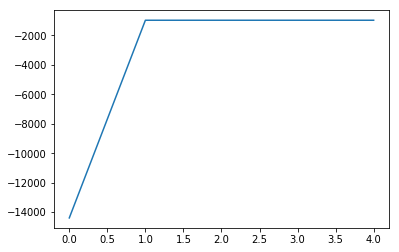

2018-05-15 0.35702038 0.48185235 0.12483197


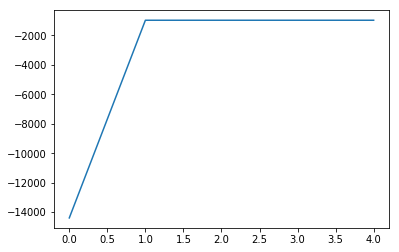

2018-05-16 0.85269925 0.09551947 0.75717978


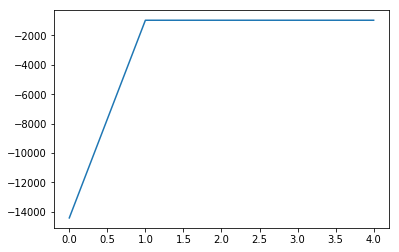

2018-05-17 0.88425055 0.36526662 0.51898393


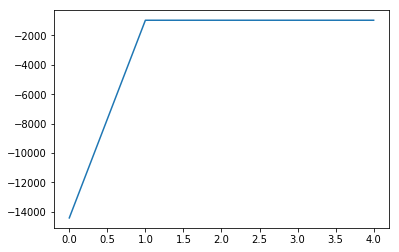

2018-05-18 -0.33023612 -0.38758767 0.05735154


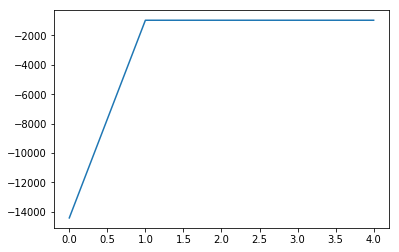

2018-05-21 -0.25518029 -0.45020797 0.19502769


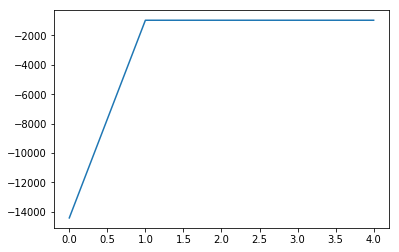

2018-05-22 -0.56124287 0.19839455 0.75963743


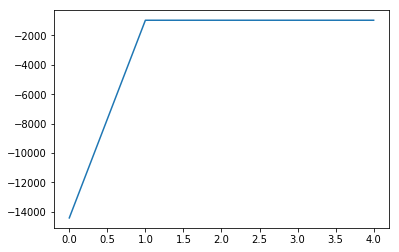

2018-05-23 -0.60261499 -0.37857598 0.22403901


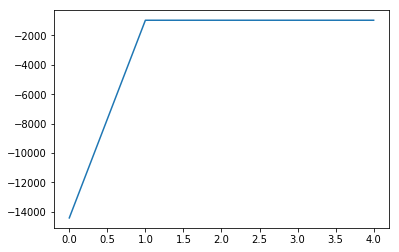

2018-05-24 0.43280789 0.01105739 0.42175050


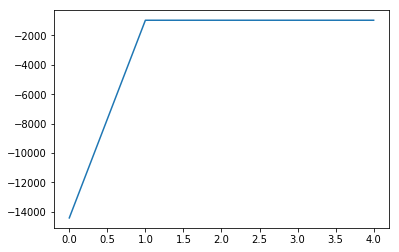

2018-05-25 0.85011657 0.29331297 0.55680360


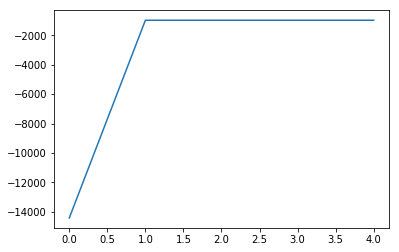

2018-05-28 0.04875880 -0.12015396 0.16891276


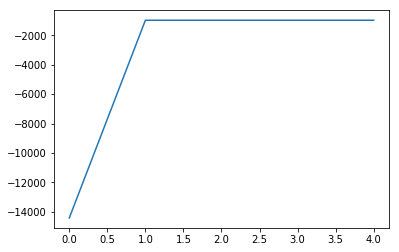

2018-05-29 -0.25554180 -0.20393783 0.05160397


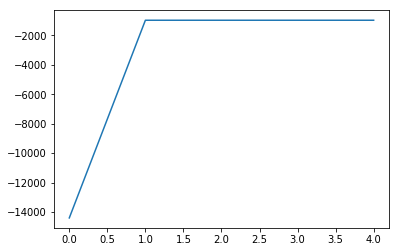

2018-05-30 -0.44723296 -0.03051085 0.41672211


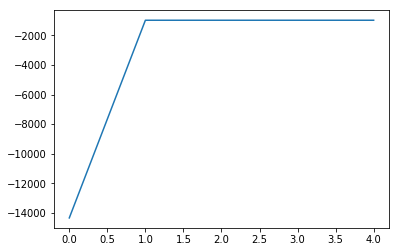

2018-05-31 -0.25727248 -0.23182797 0.02544451


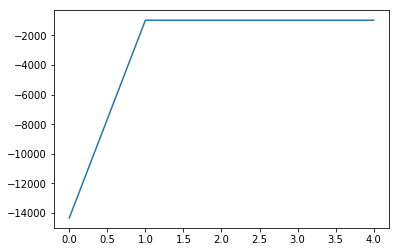

2018-06-01 -0.33479750 0.37881569 0.71361318


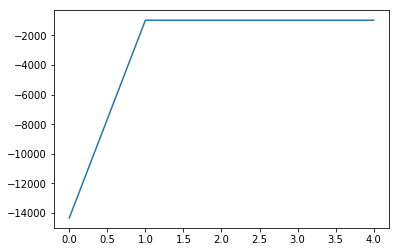

2018-06-04 0.31796568 0.47156632 0.15360064


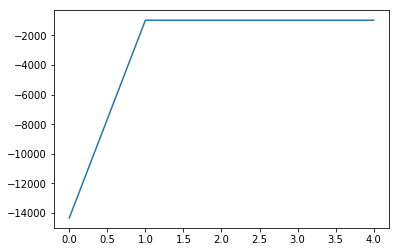

2018-06-05 -0.02760010 0.29794785 0.32554795


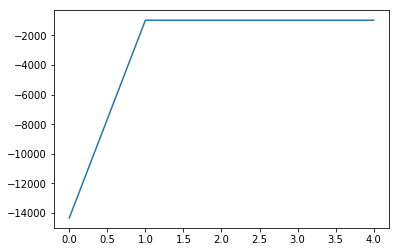

2018-06-06 0.69914673 -0.20259327 0.90174000


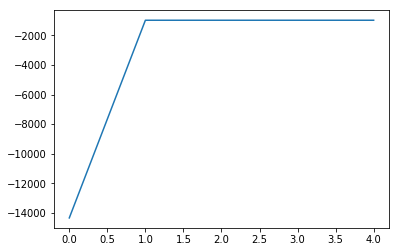

2018-06-07 1.18648433 0.80280924 0.38367510


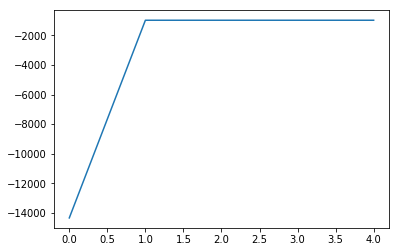

2018-06-08 -0.55660425 -0.40003487 0.15656937


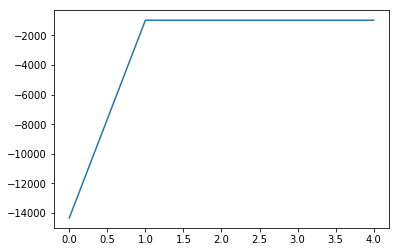

2018-06-11 -0.14102762 -0.17649457 0.03546695


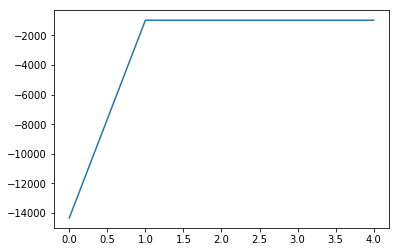

2018-06-12 0.04872013 -0.02225855 0.07097868


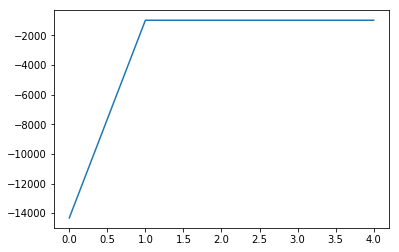

2018-06-13 -1.36416206 -0.06296469 1.30119737


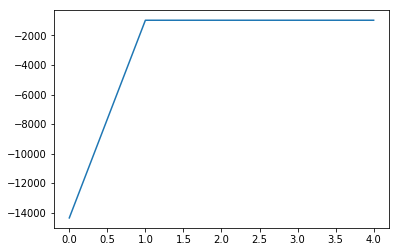

2018-06-14 -0.25856218 -0.58703232 0.32847013


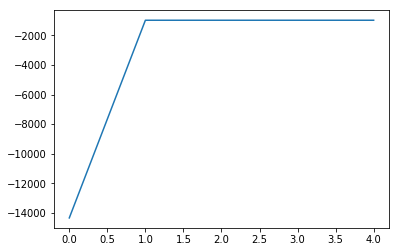

2018-06-15 -1.38463400 -0.45578900 0.92884500


In [90]:
result = run_experiment(mkl_krr, al_log_return, start_num=1700, period=1000, day=1)

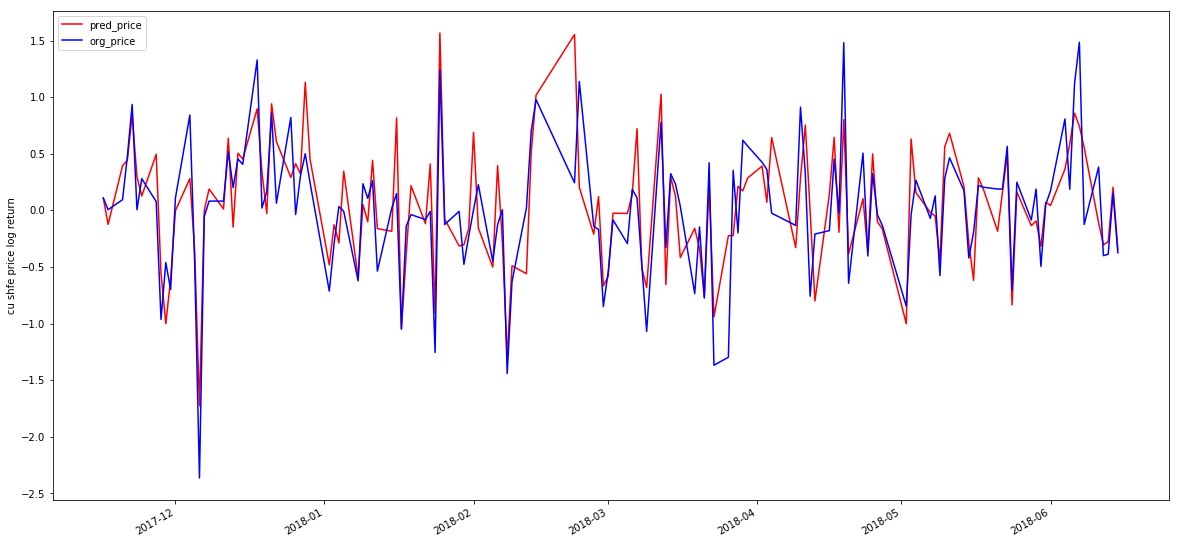

In [96]:
plot_result(result, 'cu')

In [91]:
print(evaluate('krr_test', result['org_price'].values, result['pred_price'].values))

               MSE       MAE              RMSE       DTW Spearmanr  \
krr_test  0.698727  0.635491  [0.835898865486]  0.928845  0.403502   

              p-value  
krr_test  4.44403e-08  


/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

In [92]:
import datetime
class mkl_feature_selection:
    def __init__(self, X, Y, lag_num):
        self.X = X
        #shift X may have nan value. select available part 
        self.Y = Y
        self.data_num = self.X.shape[0]
        self.feature_num = self.X.shape[1]
        self.kernel_num = 7
        #sample size of kernel's hyperparameter
        self.bound_num = 6
        self.kernel_param_bound = np.logspace(-5, 5, self.bound_num)
        #sample size of lag (0,1,2,3,4,5)
        #self.lag_num = lag_num
        #self.lag_bound = np.linspace(0,self.lag_num-1,self.lag_num, dtype=int)
        #total individual kernel num
        self.num = self.feature_num  * self.kernel_num * self.bound_num
        #store the weights of each kernel
        self.weights = np.zeros(shape=(self.num,1)) 
        #gradient for every update
        self.grad = np.zeros(shape=(self.num,1)) *  (1/self.num)
        #remove nan data
        self.avail_start = self.X.index[0]
        #initial weights for each kernel
        self.init =  np.ones(shape=(self.num,1)) *  (1/self.num)
        #combined kernel
        self.cov = 0
        #inverse combined kernel
        self.optimise = 10
        self.covinv = 0
        self.alpha = []
        self.alpha_ = []
        self.kernel = []
    
    #feature with different lag and combine to one dataset
    def build_dataset(self):
        dataset =np.zeros(shape=(self.feature_num, self.data_num))
        for i in range(self.feature_num):        
            df_Xy = self.X.iloc[:,i]
            dataset[i,:] = df_Xy         
        return dataset
    
    # individual kernels: num_feature * num_lag * num_kernel_type * num_kernel_hyperparameter
    def construct_kernel(self, dataset):
        
        len_ = self.data_num
        kernel = np.zeros(shape=(self.num, len_, len_))
        index = 0
        for i in range(self.feature_num):
            
                X = dataset[i,:] 
                X = X.reshape((len_, 1))
                for hyper_param in self.kernel_param_bound:
                    k1 = ConstantKernel(constant_value= hyper_param, constant_value_bounds=(1e-05, 100000.0))
                    k2 = RBF(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0))
                    k3 = Matern(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
                    k4 = RationalQuadratic(length_scale=hyper_param, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
                    k5 = ExpSineSquared(length_scale=hyper_param, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
                    k6 = DotProduct(sigma_0=hyper_param, sigma_0_bounds=(1e-05, 100000.0))
                    k7 = WhiteKernel(noise_level=hyper_param, noise_level_bounds=(1e-05, 100000.0))
    
                    kernel[index] = k1(X, X)            
                    kernel[index+1] = k2(X, X)
                    kernel[index+2] = k3(X, X)
                    kernel[index+3] = k4(X, X)
                    kernel[index+4] = k5(X, X)
                    kernel[index+5] = k6(X, X)
                    kernel[index+6] = k7(X, X)
                    index = index+7
                    
        return kernel
    
    def compute_alpha(self, weights, kernel):
        self.cov = np.sum(weights[:,:,None]*kernel,axis=0)
        self.invcov  = np.linalg.inv(self.cov)
        return np.dot(self.invcov, self.Y)
            
    #compute weight of multiple kernel    
    def fit(self, kernel): 
        model = Align()
        model.fit(kernel, self.Y.values)
        self.weights = model.mu.reshape(self.num, 1)
#         self.alpha = self.compute_alpha(self.init, kernel)
#         for j in range(self.optimise):
#             for i in range(self.num):
#                 self.grad[i] = np.dot(np.dot(self.alpha.T, kernel[i]), self.alpha)
#             self.grad = self.grad / np.linalg.norm(self.grad,ord=2) 
#             self.weights = self.init +  np.linalg.norm(self.weights-self.init,ord=2) * self.grad
#             self.alpha = self.compute_alpha(self.weights, kernel)    
        
        return self.weights
        
    def process(self):
        dataset = self.build_dataset()
        kernel = self.construct_kernel(dataset)
        weights = self.fit(kernel)
        print(weights.shape)
        return weights
    
    
    def plot_feature_kernel(self, weights):
        weights_ = weights.reshape((self.feature_num, self.bound_num, self.kernel_num))
        weights_1 = np.sum(weights_,axis=1)
        # select lag for each feature through weights
#         index =  np.argmax(weights_1, axis=1)
#         weights_2 = np.sum(weights_, axis=3)
#         matrix = np.zeros((self.feature_num, self.kernel_num))
#         for i in range(len(index)):
#             matrix[i] = weights_2[i,index[i],:]
        fig = plt.imshow(weights_1, cmap='hot', interpolation='nearest')
        plt.xlabel('kernel')
        plt.ylabel('features')
        
        plt.xticks([0, 1, 2, 3, 4, 5, 6],[r'$Const$',r'$RBF$',  r'$Matern$',  r'$RQ$',  r'$ES$',  r'$DP$', r'$White$'])
        plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],[r'$lme\_stocks$', r'$lme\_prices$', r'$ted$', r'$ted\_spread$', r'$bdi$',r'$vix$',r'$gsci$', r'$shfe\_price$' ])
        #fig.set_size_inches(10,10)
        plt.colorbar() 
        plt.show()

In [93]:
# X: cu_log_return[:-1,:] Y: cu_log_return[1:,-1] 
def feature_selection(X,Y, lag_num=6):
    feature_num = X.shape[1]
    mkl_select = mkl_feature_selection(X, Y, lag_num)  
    weights = mkl_select.process()
    #plot
    #mkl_select.plot_feature_lag(weights)
    mkl_select.plot_feature_kernel(weights)
    return weights

Start Date 2013-05-02 00:00:00
End Date 2018-06-15 00:00:00
(336, 1)


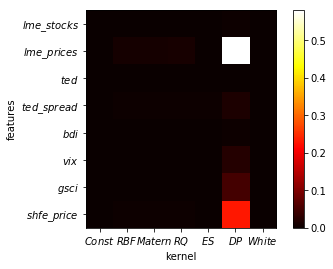

In [102]:
# simple test
start=1621
print('Start Date', al_log_return.index[start])
stop= 2871
print('End Date', al_log_return.index[stop])
weights = feature_selection(al_log_return.iloc[start:stop,:], al_log_return.iloc[start+1:stop+1,-1] , lag_num=6)

In [ ]:
def run_experiment_2(function, input_dataset, period=100, lag=1, feature_select_lag = 5):
    num, feature = input_dataset.shape
    i = 2150
    df = pd.DataFrame(data=[], index=input_dataset.index[(i+period +lag) :], columns=['org_price','pred_price','error'])
      
    while (i+period+lag) != num :   

        X_valid = input_dataset.iloc[i:i+period+1,:]
        Y_valid = input_dataset.iloc[i+lag:i+period+lag, -1]  

        X_train, Y_train, X_pred = feature_select(X_valid, Y_valid, feature_select_lag)

        y_pred = function(X_train, Y_train, X_pred)
        y_org = input_dataset.iloc[i+period+lag, -1]     
        error = np.abs(y_org - y_pred)
        pred_date = input_dataset.index[i+period+lag].strftime('%Y-%m-%d')

        df.set_value(pred_date, 'org_price', y_org)
        df.set_value(pred_date, 'pred_price', y_pred)
        df.set_value(pred_date, 'error',error)

        print(pred_date, "%.8f" % y_org, "%.8f" % y_pred, "%.8f" %error) 
        i=i+1  

    return df     

In [ ]:
def feature_select(X, Y, lag_range):
    s = mkl_select_method(X,Y, lag_range)
    x_train, y_train, x_pred =  s.process()
    return x_train, y_train, x_pred

In [ ]:
class mkl_select_method():

    def __init__(self, X, Y, lag_range):
        self.X = X
        self.Y = Y.iloc[lag_range:]
        self.X_select = self.X.iloc[:-1,:]
        self.data_num = self.X_select.shape[0]
        self.feature_num = self.X_select.shape[1]
        self.kernel_num = 7
        self.bound_num = 11
        self.kernel_param_bound = np.logspace(-5, 5, self.bound_num)
        self.lag_num = lag_range
        self.lag_bound = np.linspace(0, self.lag_num-1, self.lag_num, dtype=int)
        self.num = self.feature_num * self.lag_num * self.kernel_num * self.bound_num
        self.avail_start_date = self.X.index[lag_range]
        
        self.weights = np.zeros(shape=(self.num,1)) 
        self.grad = np.zeros(shape=(self.num,1)) *  (1/self.num)
        self.avail_start = self.X.index[self.lag_num]
        self.init =  np.ones(shape=(self.num,1)) *  (1/self.num)
        self.cov = 0
        self.covinv = 0
        self.optimise = 10
        self.alpha = []
        self.alpha_ = []
        self.kernel = [] 
        
    def lag_process(self, xs,lag):
        xs = xs.shift(periods=lag)
        return xs
    
    def build_dataset(self):
        dataset =np.zeros(shape=(self.feature_num, self.lag_num,  self.data_num -self.lag_num ))
        for i in range(self.feature_num):
            for j in range(self.lag_num):
                df_Xy = self.lag_process(self.X_select.iloc[:,i], self.lag_bound[j])
                df_Xy = df_Xy.loc[self.avail_start_date:]
                dataset[i,j,:] = df_Xy         
        return dataset
    
    def construct_kernel(self, dataset):
        len_ = self.data_num -self.lag_num
        kernel = np.zeros(shape=(self.num, len_, len_))
        index = 0
        for i in range(self.feature_num):
            for j in range(self.lag_num):
                X = dataset[i,j,:] 
                X = X.reshape((len_, 1))
                for hyper_param in self.kernel_param_bound:
                    k1 = ConstantKernel(constant_value= hyper_param, constant_value_bounds=(1e-05, 100000.0))
                    k2 = RBF(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0))
                    k3 = Matern(length_scale=hyper_param, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
                    k4 = RationalQuadratic(length_scale=hyper_param, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
                    k5 = ExpSineSquared(length_scale=hyper_param, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
                    k6 = DotProduct(sigma_0=hyper_param, sigma_0_bounds=(1e-05, 100000.0))
                    k7 = WhiteKernel(noise_level=hyper_param, noise_level_bounds=(1e-05, 100000.0))
                       
                    kernel[index] = k1(X, X)
                    kernel[index+1] = k2(X, X)
                    kernel[index+2] = k3(X, X)
                    kernel[index+3] = k4(X, X)
                    kernel[index+4] = k5(X, X)            
                    kernel[index+5] = k6(X, X)
                    kernel[index+6] = k7(X, X)
                    index = index+7              
        return kernel
    
    def compute_alpha(self, weights, kernel):
        self.cov = np.sum(weights[:,:,None]*kernel,axis=0)
        self.invcov  = np.linalg.inv(self.cov)
        return np.dot(self.invcov, self.Y)
        
    def fit(self, kernel):       
#         model = Align()
#         model.fit(kernel, self.Y)
#         weights = model.mu.reshape((self.num,1))

        self.alpha = self.compute_alpha(self.init, kernel)
        for j in range(self.optimise):
            for i in range(self.num):
                self.grad[i] = np.dot(np.dot(self.alpha.T, kernel[i]), self.alpha)
            self.grad = self.grad / np.linalg.norm(self.grad,ord=2) 
            self.weights = self.init +  np.linalg.norm(self.weights-self.init,ord=2) * self.grad
            self.alpha = self.compute_alpha(self.weights, kernel) 
        weights = self.weights
        
        
        weights = weights.reshape(( self.feature_num , self.lag_num , self.kernel_num , self.bound_num))
        weights_ = np.sum(np.sum(weights,axis=3), axis=2)
        index = np.argmax(weights_, axis=1)
        return weights, index
    
    def rebuild_dataset(self,index):
        for i in range(len(index)):
            self.X.iloc[:,i].shift(periods = index[i])
        X_train = self.X.iloc[self.lag_num:-1,:]
        X_pred = self.X.iloc[-1:,:]
        return X_train, X_pred
        
    def process(self):
        dataset = self.build_dataset()
        kernel = self.construct_kernel(dataset)
        weights, index = self.fit(kernel)
        X_train, X_pred = self.rebuild_dataset(index)
        Y_train = self.Y
        return X_train, Y_train, X_pred
        

In [96]:
file_name = 'cu_DP_WHITE_1000.csv'
save_csv = STORE_DIR + file_name
data =  pd.read_csv(save_csv, index_col=0, parse_dates=True, dayfirst=True)

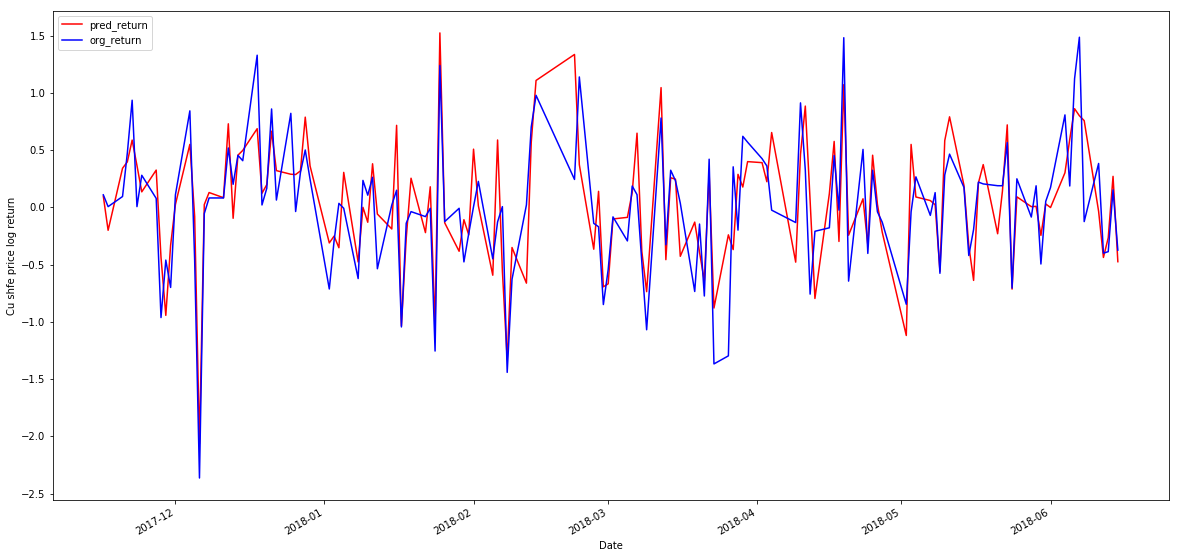

In [100]:
plot_result(data, 'Cu')

In [101]:
print(evaluate('', data['org_price'].values, data['pred_price'].values))

       MSE       MAE      RMSE       DTW Spearmanr     p-value
  0.124106  0.273497  0.352287  0.100824  0.776808  6.5783e-30


/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/elvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor